In [179]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 



import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re 
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec
import torch 
import torch.nn as nn  
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset
# from torchmetrics import ConfusionMatrix 
# from mlxtend.plotting import plot_confusion_matrix

lemma = WordNetLemmatizer()
lb = LabelEncoder()

In [ ]:
nltk.download('wordnet')

In [180]:
data=pd.read_csv("C:/Users/sarth/OneDrive/Desktop/ml_research_paper/twitter_training.csv")
data

,SR.NO,COUNTRY,SENTIMENT,TWEET
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [181]:
data=data.head(25000)

In [182]:
data

,SR.NO,COUNTRY,SENTIMENT,TWEET
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
24995,4691,Google,Positive,That bad commercial tho.
24996,4692,Google,Neutral,How to not be jaded about every single fucking...
24997,4692,Google,Neutral,How not to get bored about every damn thing in...
24998,4692,Google,Neutral,How not to stutter about every fucking thing i...


In [183]:
print(np.unique(data['SENTIMENT']))


['Irrelevant' 'Negative' 'Neutral' 'Positive']


In [184]:
print(data.isnull().sum())

SR.NO          0
COUNTRY        0
SENTIMENT      0
TWEET        224
dtype: int64


In [185]:
mode_value=data['TWEET'].mode()[0]
data['TWEET'].fillna(mode_value,inplace=True)
print(data.isnull().sum())


SR.NO        0
COUNTRY      0
SENTIMENT    0
TWEET        0
dtype: int64


C:\Users\sarth\AppData\Local\Temp\ipykernel_9032\4169983336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TWEET'].fillna(mode_value,inplace=True)


In [186]:
data.head()

,SR.NO,COUNTRY,SENTIMENT,TWEET
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [187]:
labels = {key : value for value , key in enumerate(np.unique(data['SENTIMENT']))}
labels

{'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}

In [188]:
#original labels

def label(n) : 
    for x , y in labels.items() : 
        if y==n : 
            return x

<Axes: xlabel='SENTIMENT', ylabel='count'>

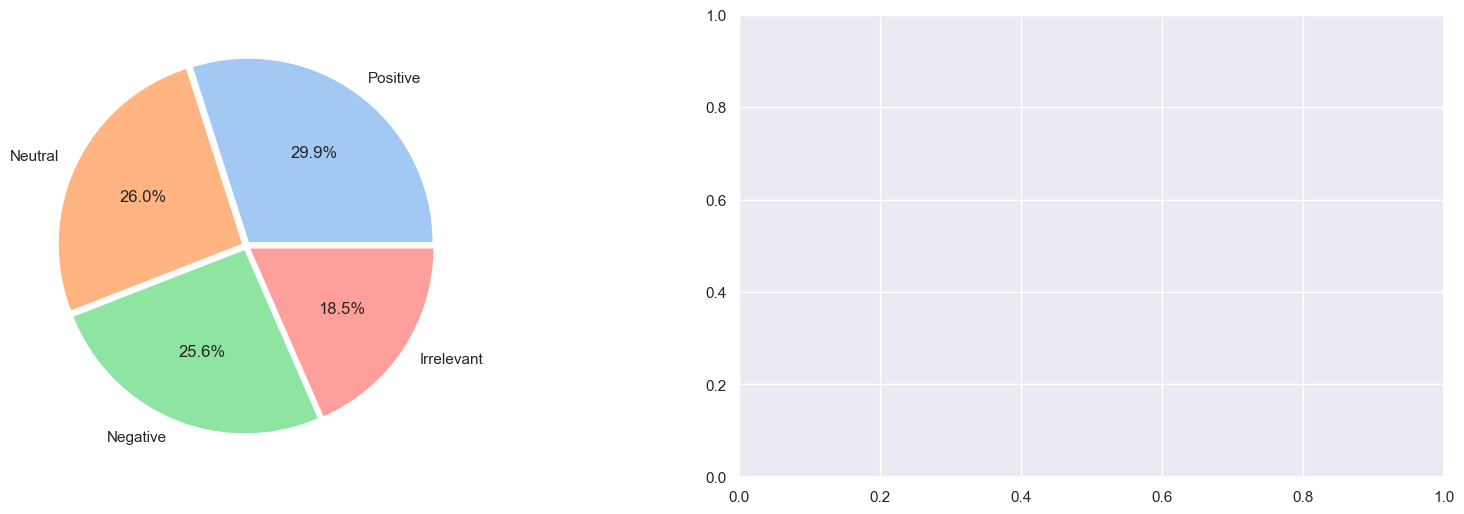

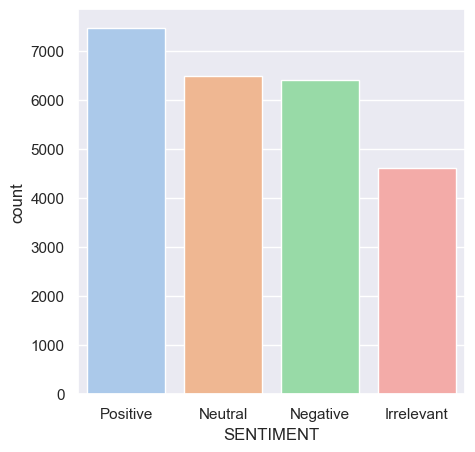

In [189]:
label_count = data['SENTIMENT'].value_counts()
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)
# plt.show()
axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
# axes[0].set_title('Percentage Label')

# sns.countplot(data['SENTIMENT'] , ax=axes[1])
# axes[1].set_title('Count Label')
# axes[1].set_xlabel('Label')
# axes[1].set_ylabel('Count')
fig = plt.figure(figsize=(5,5))
sns.countplot(x='SENTIMENT', data = data)

# plt.tight_layout()



In [190]:
punc = list(punctuation) 
punc
print(stopwords)

<WordListCorpusReader in 'C:\\Users\\sarth\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


In [191]:
def words_used(tweets , num_of_words) : 
    all_text = ''.join(data[tweets].values) 
    
    all_text = re.sub('<.*?>', '', all_text) # HTML tags
    all_text = re.sub(r'\d+', '', all_text) # numbers
    all_text = re.sub(r'[^\w\s]', '', all_text) # special characters
    all_text = re.sub(r'http\S+', '', all_text) # URLs or web links
    all_text = re.sub(r'@\S+', '', all_text) # mentions
    all_text = re.sub(r'#\S+', '', all_text) # hashtags
    
    words = all_text.split() 
    
    # remove puncs 
    punc = list(punctuation) 
    words = [word for word in words if word not in punc]
    
    # remove stopwords 
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    
    word_counts = Counter(words)
    
    top_words = word_counts.most_common(num_of_words)
    
    return top_words

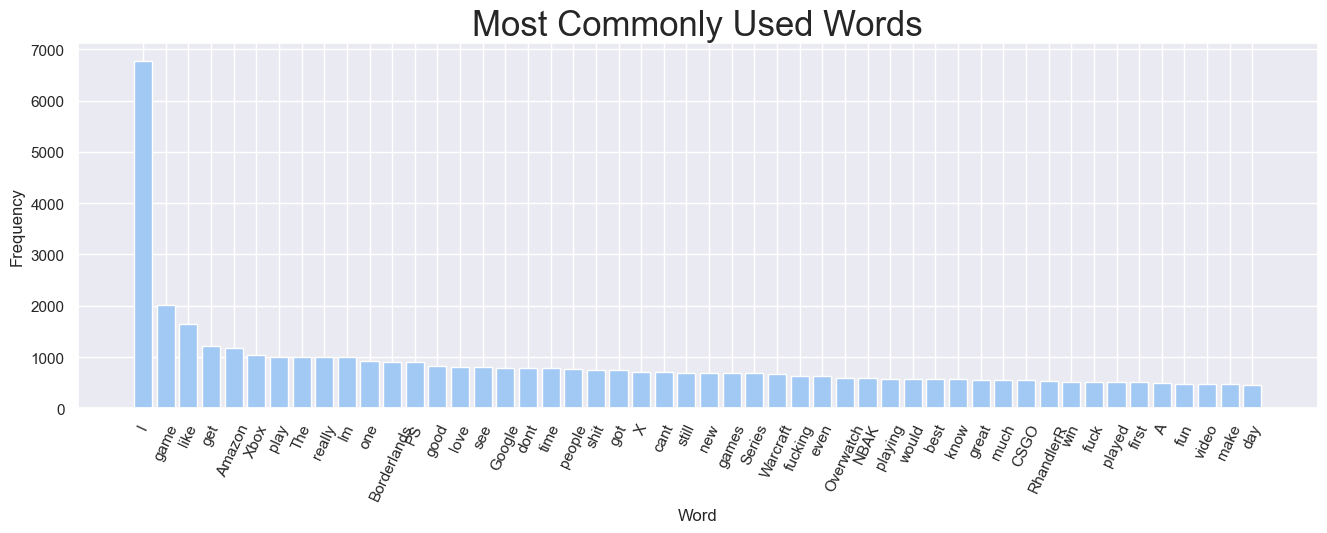

In [192]:
top_words = words_used('TWEET' , 50)

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(16,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=25)
plt.xticks(rotation=65)
plt.subplots_adjust(bottom=0.15)
plt.show()

In [229]:
def DataPrep(text) : 
    text = re.sub('<.*?>', '', text) # HTML tags
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    text = re.sub(r'http\S+', '', text) # URLs or web links
    text = re.sub(r'@\S+', '', text) # mentions
    text = re.sub(r'#\S+', '', text) # hashtags
    
    # tokenization 
    tokens = nltk.word_tokenize(text) 
    
    # remove puncs 
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]
    
    # remove stopwords 
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word.lower() in stop_words]
    
    # Lemmatization 
    words = [lemma.lemmatize(word) for word in words] 
    
    text = ' '.join(words)
    
    return text

In [194]:
data['cleaned_tweets'] = data['TWEET'].apply(DataPrep)


C:\Users\sarth\AppData\Local\Temp\ipykernel_9032\3288654094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cleaned_tweets'] = data['TWEET'].apply(DataPrep)


In [195]:
duplicate=int(data["cleaned_tweets"].duplicated().sum())
print(duplicate)

4262


In [196]:
data.drop_duplicates("cleaned_tweets", inplace=True)


C:\Users\sarth\AppData\Local\Temp\ipykernel_9032\775799575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates("cleaned_tweets", inplace=True)


In [197]:
data.iloc[:10]

,SR.NO,COUNTRY,SENTIMENT,TWEET,cleaned_tweets
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderland murder
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hour making something fun dont know HUGE...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...,spent couple hour something fun dont know Im h...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...,spent hour something fun dont know Im HUGE Bor...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hour making something fun dont know HUGE...
11,2402,Borderlands,Positive,was,
12,2403,Borderlands,Neutral,"Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...",RockHard La Varlope RARE POWERFUL HANDSOME JAC...


In [198]:
data['tweet_len']=[len(y.split()) for y in data['cleaned_tweets']]

C:\Users\sarth\AppData\Local\Temp\ipykernel_9032\1295896258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tweet_len']=[len(y.split()) for y in data['cleaned_tweets']]


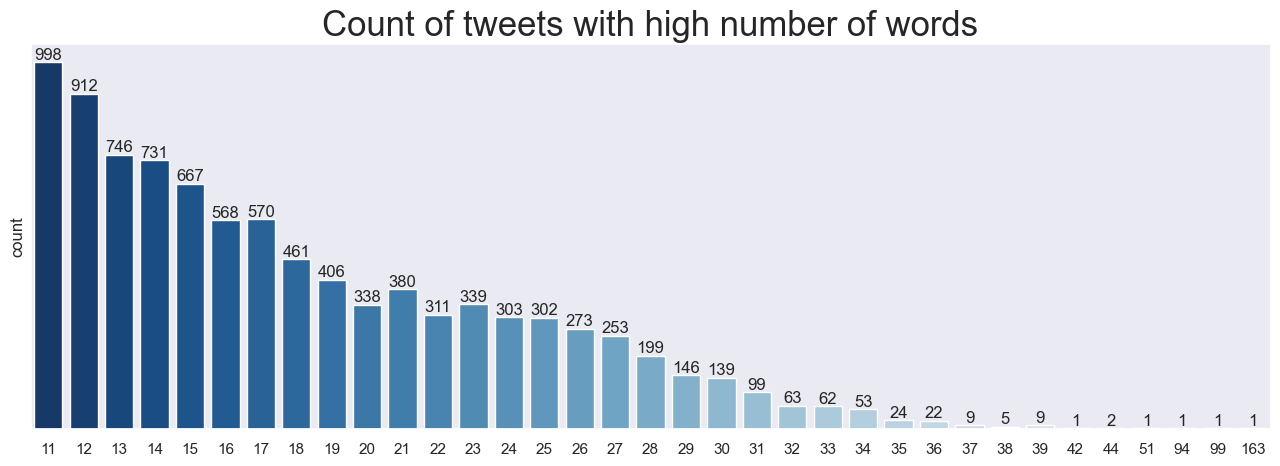

In [199]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='tweet_len', data=data[(data['tweet_len']<=1000) & (data['tweet_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [200]:
x_train,x_test,y_train,y_test=train_test_split(data['cleaned_tweets'],data['SENTIMENT'],train_size=0.85,random_state=42)

In [201]:
len(x_train),len(x_test)

(17627, 3111)

### Logistic Regression

In [202]:
vec = TfidfVectorizer()
vec.fit(x_train)


TfidfVectorizer()

In [203]:

x_train = vec.transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()



In [204]:
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [205]:

lr = LogisticRegression(random_state=42,max_iter=500)
lr.fit(x_train , y_train)


LogisticRegression(max_iter=500, random_state=42)

In [206]:
train_acc1 = lr.score(x_train , y_train)
print(train_acc1*100)

92.01792704373972


In [207]:
lr_pred = lr.predict(x_test)

val_acc1 = accuracy_score(y_test , lr_pred) 
print(val_acc1*100)

82.5136612021858


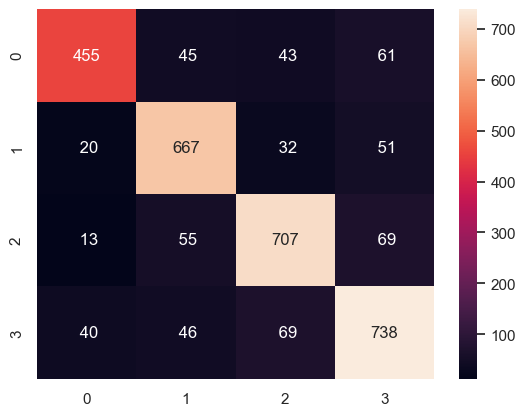

In [208]:
lr_cm = confusion_matrix(y_test , lr_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

### Multinomial 

In [209]:
multinomial_model = MultinomialNB()
multinomial_model.fit(x_train, y_train)

MultinomialNB()

In [210]:
train_accuracy_mnb = multinomial_model.score(x_train , y_train)
mnb_pred = multinomial_model.predict(x_test)

val_acc1 = accuracy_score(y_test , mnb_pred) 

val_precision1 = precision_score(y_test , mnb_pred , average='weighted')
val_recall1 = recall_score(y_test , mnb_pred , average='weighted')
val_f1score1 = f1_score(y_test , mnb_pred , average='weighted')

print("FOR MULTINOMIAL NAIVE BAYES: \n")
print(f"Training accuracy: {(train_accuracy_mnb*100):0.2f}%\n")
print(f"Validation accuracy: {(val_acc1*100):0.2f}%\n")
print(f"Precision: {val_precision1:0.2f}\n")
print(f"Recall: {val_recall1:0.2f}\n")
print(f"The f1 score: {val_f1score1:0.2f}\n")

FOR MULTINOMIAL NAIVE BAYES: 

Training accuracy: 85.49%

Validation accuracy: 77.27%

Precision: 0.80

Recall: 0.77

The f1 score: 0.77



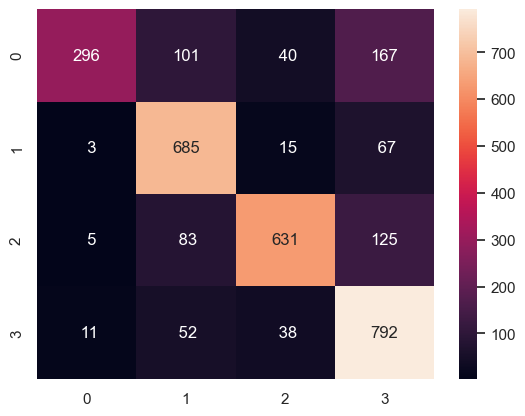

In [211]:
mnb_cm = confusion_matrix(y_test , mnb_pred)
sns.heatmap(mnb_cm, annot=True,fmt='3g')
plt.show()

In [95]:
data=data.head(2000)

In [28]:
data

,SR.NO,COUNTRY,SENTIMENT,TWEET,cleaned_tweets,tweet_len
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderland murder,4
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill,3
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderland kill,4
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderland murder,4
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hour making something fun dont know HUGE...,25
...,...,...,...,...,...,...
4826,30,Amazon,Positive,"While in quarantine, I ordered 9 Amazon parcel...",quarantine ordered Amazon parcel one week,6
4827,30,Amazon,Positive,Being in Japan has caused me to order 9 Amazon...,Japan caused order Amazon package one week,7
4828,30,Amazon,Positive,4 Being in quarantine has probably caused me t...,quarantine probably caused order Amazon movie ...,9
4829,30,Amazon,Positive,Being in quarantine has caused us to order 9 A...,quarantine caused u order Amazon package one week,8


### LSTM

In [96]:
def lstm_prep(column , seq_len) : 
    corpus = [word for text in column for word in text.split()]
    words_count = Counter(corpus) 
    sorted_words = words_count.most_common()
    vocab_to_int = {w:i+1 for i , (w,c) in enumerate(sorted_words)}
    
    text_int = [] 
    
    for text in column : 
        token = [vocab_to_int[word] for word in text.split()]
        text_int.append(token)
        
    features = np.zeros((len(text_int) , seq_len) , dtype = int)
 
    for idx , y in tqdm(enumerate(text_int)) : 
        if len(y) <= seq_len : 
            zeros = list(np.zeros(seq_len - len(y)))
            new = zeros + y
            
        else : 
            new = y[:seq_len]
            
        features[idx,:] = np.array(new)
        
        
    return sorted_words, features

In [97]:
vocabulary , tokenized_column = lstm_prep(data['cleaned_tweets'] , 34)


0it [00:00, ?it/s]

In [31]:
print(vocabulary)

[('Borderlands', 1061), ('game', 618), ('Black', 362), ('War', 360), ('Cold', 344), ('like', 340), ('Ops', 335), ('borderland', 323), ('Im', 320), ('play', 253), ('really', 249), ('good', 224), ('get', 224), ('love', 208), ('time', 198), ('fun', 180), ('look', 177), ('one', 174), ('new', 172), ('shit', 169), ('see', 154), ('cant', 153), ('playing', 140), ('na', 140), ('video', 133), ('still', 132), ('would', 131), ('dont', 127), ('day', 127), ('much', 123), ('best', 122), ('today', 118), ('going', 117), ('actually', 114), ('make', 113), ('played', 112), ('excited', 112), ('work', 111), ('stream', 110), ('even', 108), ('black', 108), ('year', 105), ('fucking', 104), ('wait', 103), ('say', 102), ('want', 101), ('Ive', 100), ('ops', 100), ('Italy', 99), ('gon', 98), ('first', 97), ('feel', 96), ('people', 95), ('great', 94), ('also', 93), ('thing', 93), ('war', 93), ('know', 92), ('Duty', 92), ('got', 91), ('Call', 91), ('favorite', 90), ('back', 90), ('go', 90), ('amazing', 89), ('alread

In [98]:
print(tokenized_column)

[[   0    0    0 ...   97    3  521]
 [   0    0    0 ...  106   98  188]
 [   0    0    0 ...   97    3  188]
 ...
 [   0    0    0 ...   50  292  271]
 [   0    0    0 ...   50  292  271]
 [   0    0    0 ...   50  292 1002]]


In [99]:
data.iloc[0]

SR.NO                                                          2401
COUNTRY                                                 Borderlands
SENTIMENT                                                  Positive
TWEET             im getting on borderlands and i will murder yo...
cleaned_tweets                         im getting borderland murder
tweet_len                                                         4
Name: 0, dtype: object

In [100]:

def most_common_words(vocab):
    keys = [] 
    values = [] 
    for key, value in vocab[:30]:
        keys.append(key) 
        values.append(value)
    
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=keys, y=values, palette='mako')
    plt.title('Top 20 most common words', size=25)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')
    plt.ylabel("Words count")
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.15)
    plt.show()


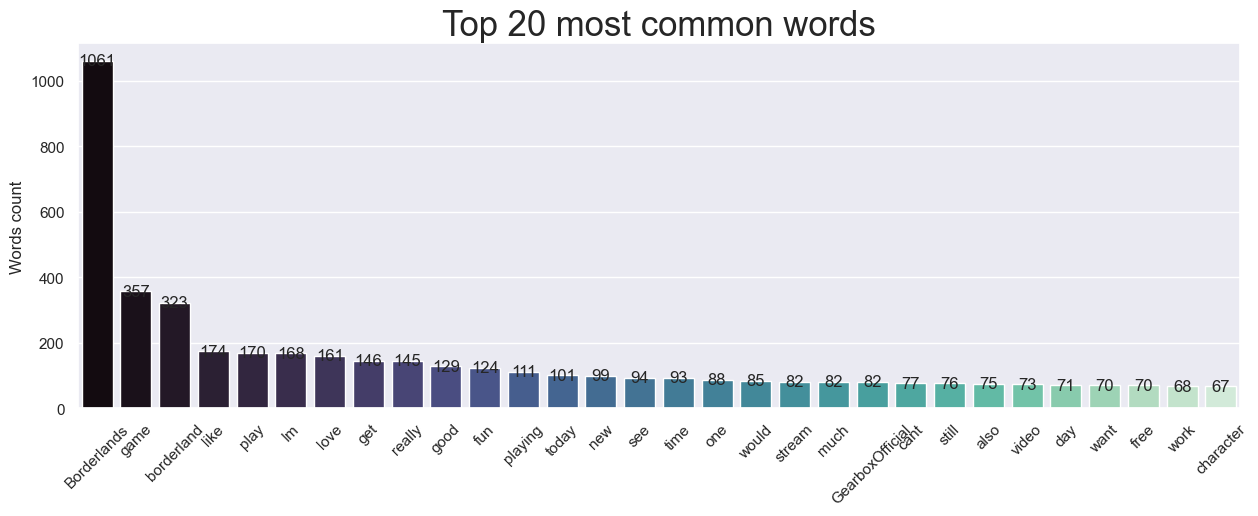

In [101]:
most_common_words(vocabulary)

In [102]:
y = lb.fit_transform(data['SENTIMENT'].values)
print(y)
# print(data['SENTIMENT'])


[3 3 3 ... 2 2 2]


In [103]:
x_train , x_test , y_train , y_test = train_test_split(tokenized_column, y , train_size=0.85 , random_state=42)


In [ ]:
multinomial_model = MultinomialNB()
multinomial_model.fit(x_train, y_train)

In [213]:
train_accuracy_mnb = multinomial_model.score(x_train , y_train)
mnb_pred = multinomial_model.predict(x_test)

val_acc2 = accuracy_score(y_test , mnb_pred) 

val_precision1 = precision_score(y_test , mnb_pred , average='weighted')
val_recall1 = recall_score(y_test , mnb_pred , average='weighted')
val_f1score1 = f1_score(y_test , mnb_pred , average='weighted')

print("FOR MULTINOMIAL NAIVE BAYES: \n")
print(f"Training accuracy: {(train_accuracy_mnb*100):0.2f}%\n")
print(f"Validation accuracy: {(val_acc2*100):0.2f}%\n")
print(f"Precision: {val_precision1:0.2f}\n")
print(f"Recall: {val_recall1:0.2f}\n")
print(f"The f1 score: {val_f1score1:0.2f}\n")

FOR MULTINOMIAL NAIVE BAYES: 

Training accuracy: 85.49%

Validation accuracy: 77.27%

Precision: 0.80

Recall: 0.77

The f1 score: 0.77



In [ ]:
mnb_cm = confusion_matrix(y_test , mnb_pred)
sns.heatmap(mnb_cm, annot=True,fmt='3g')
plt.show()

In [ ]:
train_accuracy_mnb = multinomial_model.score(x_train , y_train)
mnb_pred = multinomial_model.predict(x_test)

val_acc1 = accuracy_score(y_test , mnb_pred) 

val_precision1 = precision_score(y_test , mnb_pred , average='weighted')
val_recall1 = recall_score(y_test , mnb_pred , average='weighted')
val_f1score1 = f1_score(y_test , mnb_pred , average='weighted')

print("FOR MULTINOMIAL NAIVE BAYES: \n")
print(f"Training accuracy: {(train_accuracy_mnb*100):0.2f}%\n")
print(f"Validation accuracy: {(val_acc1*100):0.2f}%\n")
print(f"Precision: {val_precision1:0.2f}\n")
print(f"Recall: {val_recall1:0.2f}\n")
print(f"The f1 score: {val_f1score1:0.2f}\n")

In [104]:
train_data = TensorDataset(torch.from_numpy(x_train), torch.LongTensor(y_train))
val_data = TensorDataset(torch.from_numpy(x_test), torch.LongTensor(y_test))

In [105]:
punc

In [106]:
torch.manual_seed(42) 
val_dataloader = DataLoader(
    dataset = val_data , 
    batch_size = 64 , 
    shuffle=False
)

In [107]:
print(len(train_dataloader))

27


In [108]:
print((len(val_dataloader)))

5


In [109]:
list_train = list(map(lambda x: x.split(), data['cleaned_tweets']))

In [110]:
list_test=Word2Vec(list_train, vector_size=200)

In [111]:
def weight_matrix(model,vocab):
    vocab_size= len(vocab)+1
    embedding_matrix = np.zeros((vocab_size,200))
    for word, token in vocab:
        if model.wv.__contains__(word):
            embedding_matrix[token]=model.wv.__getitem__(word)
    return embedding_matrix

In [112]:
embedding_vec = weight_matrix(list_test,vocabulary)
print("Embedding Matrix Shape:", embedding_vec.shape)
print(embedding_vec)

Embedding Matrix Shape: (4109, 200)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [113]:
def param_count(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print('The Total number of parameters in the model : ', sum(params))

In [114]:
class LSTM(nn.Module) : 
    def __init__(self , vocab_size , embedding_dim 
                 , num_layers , hidden_dim , out_channels , bidirectional) : 
        super().__init__() 
         
        self.no_layers = num_layers 
        self.hidden_dim = hidden_dim 
        self.out_channels = out_channels
        self.num_directions = 2 if bidirectional else 1  
        self.embedding = nn.Embedding(vocab_size , embedding_dim)
        
        self.lstm = nn.LSTM(
            embedding_dim , 
            hidden_dim , 
            num_layers , 
            dropout = 0.5 , 
            bidirectional = bidirectional , 
            batch_first = True
        )
        
        self.fc = nn.Linear(hidden_dim*self.num_directions , out_channels)
        
        
    def forward(self , x) : 
        h0 = torch.zeros((self.no_layers * self.num_directions , x.size(0) , self.hidden_dim))
        c0 = torch.zeros((self.no_layers * self.num_directions , x.size(0) , self.hidden_dim))
        
        embedded = self.embedding(x)
        
        out , _ = self.lstm(embedded , (h0 , c0))
        
        out = out[:,-1,:]
        
        out = self.fc(out)
        
        return out

In [115]:
VOCAB_SIZE = len(vocabulary) + 1
NUM_LAYERS = 2 
OUT_CHANNELS = 4 
HIDDEN_DIM = 256
BIDIRECTIONAL = True
EMBEDDING_DIM=200

model = LSTM(VOCAB_SIZE , EMBEDDING_DIM , NUM_LAYERS , HIDDEN_DIM , OUT_CHANNELS , BIDIRECTIONAL)

model.embedding.weight.data.copy_(torch.from_numpy(embedding_vec))

model.embedding.weight.requires_grad = True

In [116]:
param_count(model)


The Total number of parameters in the model :  3338796


In [117]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=0.001)

In [118]:
epochs = 10 
training_loss = []
training_acc = [] 
for i in tqdm(range(epochs)) : 
    epoch_loss = 0
    epoch_acc = 0 
    for batch , (x_train , y_train) in enumerate(train_dataloader) : 
        y_pred = model(x_train)
        
        loss = criterion(y_pred , y_train) 
        
        if batch % 500 == 0:
            print(f"Looked at {batch * len(x_train)}/{len(train_dataloader.dataset)} samples.")
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss +=loss 
        epoch_acc += accuracy_score(y_train , y_pred.argmax(dim=1))
        
    training_loss.append((epoch_loss/len(train_dataloader)).detach().numpy())
    training_acc.append(epoch_acc/len(train_dataloader))
    print(f"Epoch {i+1}: Accuracy: {(epoch_acc/len(train_dataloader)) * 100}, Loss: {(epoch_loss/len(train_dataloader))}\n\n")
  

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/1700 samples.
Epoch 1: Accuracy: 41.4673353909465, Loss: 1.2993814945220947


Looked at 0/1700 samples.
Epoch 2: Accuracy: 49.93569958847737, Loss: 1.107724666595459


Looked at 0/1700 samples.
Epoch 3: Accuracy: 72.35725308641975, Loss: 0.609698474407196


Looked at 0/1700 samples.
Epoch 4: Accuracy: 89.26183127572016, Loss: 0.31424999237060547


Looked at 0/1700 samples.
Epoch 5: Accuracy: 95.20961934156378, Loss: 0.15521591901779175


Looked at 0/1700 samples.
Epoch 6: Accuracy: 97.89737654320987, Loss: 0.08136334270238876


Looked at 0/1700 samples.
Epoch 7: Accuracy: 98.85545267489711, Loss: 0.04472300037741661


Looked at 0/1700 samples.
Epoch 8: Accuracy: 99.53703703703704, Loss: 0.014611153863370419


Looked at 0/1700 samples.
Epoch 9: Accuracy: 99.76851851851852, Loss: 0.007959886454045773


Looked at 0/1700 samples.
Epoch 10: Accuracy: 99.71064814814815, Loss: 0.011229430325329304




In [ ]:
train_scores=[train_acc1,train_acc2,train_acc3]
val_scores=[val_acc1,val_acc2,val_acc3]

In [ ]:
scores = model.evaluate(x_test, y_test)
LSTM_accuracy = scores[1]*100
print('Test accuracy: ', scores[1]*100, '%')

In [74]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

embedding_size=32
max_words=5000

model = Sequential()
model.add(Embedding(max_words, embedding_size, input_length=x_train.shape[1]))
model.add(LSTM(100))
model.add(Dense(3,activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 32)            160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 213503 (834.00 KB)
Trainable params: 213503 (834.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [75]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [216]:
val_loss=0
val_acc3= 0
lstm_preds=[]
val_targets = []
torch.manual_seed(42)
with torch.no_grad() : 
        for x_val , y_val in tqdm(val_dataloader) : 
            y_pred=model.forward(x_val)
            val_pred = torch.softmax(y_pred , dim=1 ).argmax(dim=1)
            lstm_preds.append(val_pred)
            val_targets.extend(y_val)
            
            loss=criterion(y_pred,y_val)
            val_loss+=loss
            val_acc3 += accuracy_score(y_val , y_pred.argmax(dim=1))
            
            
val_loss/=len(val_dataloader)
val_acc3/=len(val_dataloader)
lstm_preds = torch.cat(lstm_preds)
val_targets = torch.Tensor(val_targets)

  0%|          | 0/5 [00:00<?, ?it/s]

In [218]:
train_acc3 = training_acc[-1]
val_precision3 = precision_score(val_targets,lstm_preds,average='weighted')
val_recall3 = recall_score(val_targets,lstm_preds,average='weighted')
val_f1score3 = f1_score(val_targets,lstm_preds,average='weighted')

ValueError: Unknown optimizer: 'model'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
val_loss=0
val_acc3= 0
lstm_preds=[]
val_targets = []
torch.manual_seed(42)
with torch.no_grad() : 
        for x_val , y_val in tqdm(val_dataloader) : 
            y_pred=model.forward(x_val)
            val_pred = torch.softmax(y_pred , dim=1 ).argmax(dim=1)
            lstm_preds.append(val_pred)
            val_targets.extend(y_val)
            
            loss=criterion(y_pred,y_val)
            val_loss+=loss
            val_acc3 += accuracy_score(y_val , y_pred.argmax(dim=1))
            
            
val_loss/=len(val_dataloader)
val_acc3/=len(val_dataloader)
lstm_preds = torch.cat(lstm_preds)
val_targets = torch.Tensor(val_targets)

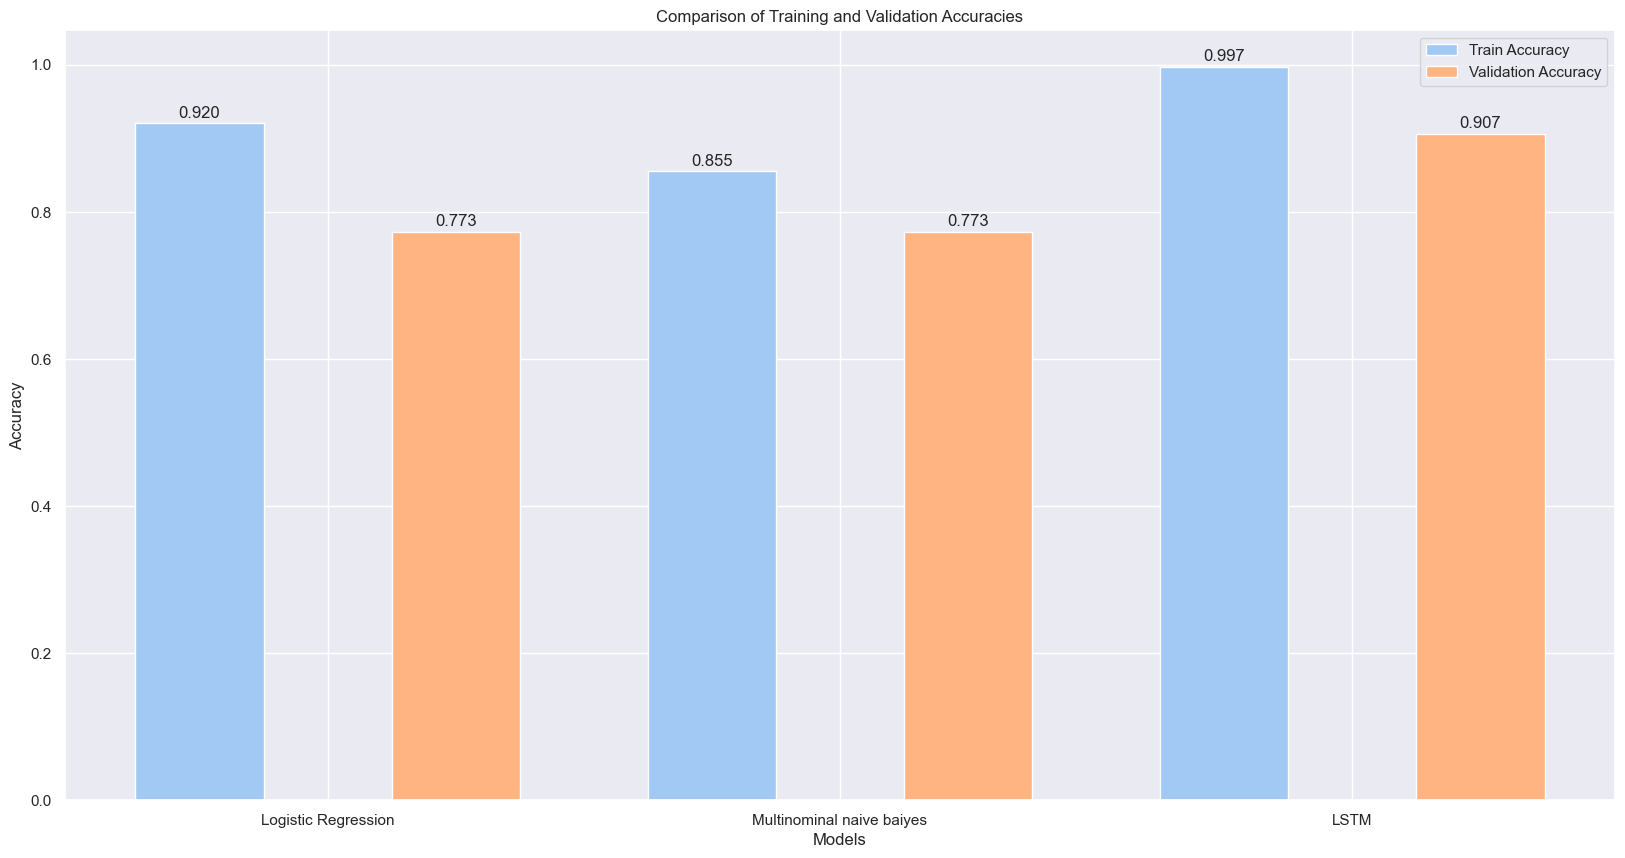

In [220]:
train_scores=[train_acc1,train_accuracy_mnb ,train_acc3]
val_scores=[val_acc1,val_acc2,val_acc3]

models = ['Logistic Regression','Multinominal naive baiyes','LSTM']

x = np.arange(len(models))

width = 0.25

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(x - width, train_scores, width, label='Train Accuracy')

rects2 = ax.bar(x + width, val_scores, width, label='Validation Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Training and Validation Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()